In [1]:
import sys
import os
import pickle
from tqdm import tqdm
sys.path.append(os.path.join(os.path.expanduser('~'), 'projects'))
import j_utils.munging as mg
from lendingclub.lc_utils import gen_datasets
import seaborn as sns

pd.options.display.max_columns = 999
pd.options.display.max_rows = 60
pd.options.display.max_seq_items = None

ppath = os.path.join(os.path.expanduser('~'), 'projects', 'lendingclub', )
dpath = os.path.join(ppath,'data')

# testing
from pandas.testing import assert_frame_equal

for each model: 

Have one overall test set

1) compare topn% of all test in aggregate, look at %def of topn

2) compare month-by-month top30%, look at %def

From the test set make 10 bootstrap month by month test sets

3) compare bootstrap month-by-month top30%, look at %def

check that higher topn% (pickier) does produce better returns

## baselines

In [4]:
def add_score_from_df(eval_loan_info, test):
    '''
    Adds scores to test (missing scores) from eval_loan_info (has scores)
    '''
    test = test.copy()
    test_ids = test['id'].values
    eval_loan_info = eval_loan_info.set_index('id')
    eval_loan_info = eval_loan_info.loc[test_ids]
    eval_loan_info = eval_loan_info.reset_index()
    for col in eval_loan_info:
        if 'score' in col:
            if col not in test:
                test[col] = eval_loan_info[col].values
    return test

def get_topn_ret(model, eval_df, n, return_col='0.07', bootstrap=False):
    '''
    Picks loans and get returns based on maximizing model_score
    '''
    assert n <= 1
    assert n >= 0
    if bootstrap:
        eval_df = eval_df.sample(frac=1, replace=True)
    return eval_df.nlargest(round(len(eval_df)*n), f'{model}_score')['0.07'].mean()

def get_topn_def_pct(model, eval_df, n, bootstrap=False):
    assert n <= 1
    assert n >= 0
    if bootstrap:
        eval_df = eval_df.sample(frac=1, replace=True)
    n_pick = round(len(eval_df)*n)
    return eval_df.nlargest(n_pick, f'{model}_score')['target_strict'].sum()/n_pick

In [15]:
test_eval_loan_info = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info.fth'))
eval_loan_info = pd.read_feather(os.path.join(dpath, 'eval_loan_info_scored.fth'))
base_loan_info = pd.read_feather(os.path.join(dpath, 'base_loan_info.fth'))
test_eval_loan_info = add_score_from_df(eval_loan_info, test_eval_loan_info)

del eval_loan_info # to not confuse myself

# load bootstrapped datasets and setup
teli0 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_0_bootstrap.fth'))
teli0 = add_score_from_df(test_eval_loan_info, teli0)
idg0 = teli0.groupby('issue_d')

teli1 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_1_bootstrap.fth'))
teli1 = add_score_from_df(test_eval_loan_info, teli1)
idg1 = teli1.groupby('issue_d')

teli2 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_2_bootstrap.fth'))
teli2 = add_score_from_df(test_eval_loan_info, teli2)
idg2 = teli2.groupby('issue_d')

teli3 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_3_bootstrap.fth'))
teli3 = add_score_from_df(test_eval_loan_info, teli3)
idg3 = teli3.groupby('issue_d')

teli4 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_4_bootstrap.fth'))
teli4 = add_score_from_df(test_eval_loan_info, teli4)
idg4 = teli4.groupby('issue_d')

teli5 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_5_bootstrap.fth'))
teli5 = add_score_from_df(test_eval_loan_info, teli5)
idg5 = teli5.groupby('issue_d')

teli6 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_6_bootstrap.fth'))
teli6 = add_score_from_df(test_eval_loan_info, teli6)
idg6 = teli6.groupby('issue_d')

teli7 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_7_bootstrap.fth'))
teli7 = add_score_from_df(test_eval_loan_info, teli7)
idg7 = teli7.groupby('issue_d')

teli8 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_8_bootstrap.fth'))
teli8 = add_score_from_df(test_eval_loan_info, teli8)
idg8 = teli8.groupby('issue_d')

teli9 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_9_bootstrap.fth'))
teli9 = add_score_from_df(test_eval_loan_info, teli9)
idg9 = teli9.groupby('issue_d')

In [210]:
from typing import List

def plot_mbm(df, ylower=-0.15, yupper=0.15, xlims=None):
    '''
    xlims should be tuple of lower and upper (date)
    '''
    for n, group in df.T.groupby(level=0):
        ax = group.dropna(axis=1).T.plot(figsize=(16,6))
        ax.set_ylim(ylower, yupper)
        if xlims:
            ax.set_xlim(xlims)
        
def plot_bsmbm(df, ylower=-0.15, yupper=0.15, xlims=None, target = 'return'):
    '''
    xlims should be tuple of lower and upper (date)
    '''
    for n, grp in df.groupby(['topn']):
        plt.figure(figsize=(16,6))
        ax = sns.lineplot(x='month', y=target, hue = 'model', data=grp)    
        ax.set_ylim(ylower, yupper)
        ax.set_title('top {0} pct bootstrapped month-by-month'.format(n))
        ax.set_xlabel('')
        if xlims:
            ax.set_xlim(xlims)
        plt.xticks(rotation=50)
        plt.show() 

def make_comparison_dfs(models: List, top_n: List, bs_groups: List, issue_d_g: List, test_eval_loan_info):
    full = {}
    mbm = {}
    bsmbm = {}
    full_def = {}
    mbm_def = {}
    bsmbm_def = {}
    for n in tqdm(top_n):
        full_h = {}
        mbm_h = {}
        bsmbm_h = {}
        full_def_h = {}
        mbm_def_h = {}
        bsmbm_def_h = {}

        for model in models:
            # get overall top n%
            full_h[model] = get_topn_ret(model, test_eval_loan_info, n)
            full_def_h[model] = get_topn_def_pct(model, test_eval_loan_info, n)

            # get month by month
            temp_mbm = {}
            temp_mbm_def = {}
            for d, g in issue_d_g:
                temp_mbm[d] = get_topn_ret(model, g, n)
                temp_mbm_def[d] = get_topn_def_pct(model, g, n)
            mbm_h[model] = temp_mbm
            mbm_def_h[model] = temp_mbm_def

            # get bsmbm
            temp_bsmbm = {}
            temp_bsmbm_def = {}
            for i, grouper in enumerate(bs_groups):
                temp = {}
                temp_def = {}
                for d, g in grouper:
                    temp[d] = get_topn_ret(model, g, n)
                    temp_def[d] = get_topn_def_pct(model, g, n)
                temp_bsmbm[i] = temp
                temp_bsmbm_def[i] = temp_def
            bsmbm_h[model] = temp_bsmbm
            bsmbm_def_h[model] = temp_bsmbm_def

        n = str(n)
        full[n] = full_h
        mbm[n] = mbm_h
        bsmbm[n] = bsmbm_h
        full_def[n] = full_def_h
        mbm_def[n] = mbm_def_h
        bsmbm_def[n] = bsmbm_def_h
        
    # whole_topn
    whole_topn_df = pd.DataFrame(full)
    # whole_topn_def
    whole_topn_def_df = pd.DataFrame(full_def)
    # reshape mbm
    reshaped = {(n, model): values for n, innerdict in mbm.items() for model, values in innerdict.items()}
    mbm_topn_df = pd.DataFrame(reshaped)
    # reshape mbm_def
    reshaped = {(n, model): values for n, innerdict in mbm_def.items() for model, values in innerdict.items()}
    mbm_topn_def_df = pd.DataFrame(reshaped)
    # reshape bsmbm
    reshaped = {(n, model, trial): values for n, innerdict in bsmbm.items() for model, subdict in innerdict.items() for trial, values in subdict.items()}
    bsmbm_topn_df = pd.DataFrame(reshaped)
    bsmbm_topn_df = bsmbm_topn_df.unstack().to_frame()
    bsmbm_topn_df.columns = ['return']
    bsmbm_topn_df.index.names=['topn', 'model', 'trial', 'month']
    bsmbm_topn_df.reset_index(inplace=True)
    # reshape bsmbm_def
    reshaped = {(n, model, trial): values for n, innerdict in bsmbm_def.items() for model, subdict in innerdict.items() for trial, values in subdict.items()}
    bsmbm_topn_def_df = pd.DataFrame(reshaped)
    bsmbm_topn_def_df = bsmbm_topn_def_df.unstack().to_frame()
    bsmbm_topn_def_df.columns = ['default_rate']
    bsmbm_topn_def_df.index.names=['topn', 'model', 'trial', 'month']
    bsmbm_topn_def_df.reset_index(inplace=True)
    return whole_topn_df, whole_topn_def_df, mbm_topn_df, mbm_topn_def_df, bsmbm_topn_df, bsmbm_topn_def_df

# Create new dataframe to append/concat to saved ones

In [111]:
models = ['logistic_regr'] #'A', 'B', 'C', 'D', 'E', 'F', 'G']
top_n = [.01, .02, .03, .05, .1, .15, .2, .3]
bs_groups = [idg0, idg1, idg2, idg3, idg4, idg5, idg6, idg7, idg8, idg9]
issue_d_g = test_eval_loan_info.groupby('issue_d')

In [112]:
whole_topn_df, whole_topn_def_df, mbm_topn_df, mbm_topn_def_df, bsmbm_topn_df, bsmbm_topn_def_df = make_comparison_dfs(models, top_n, bs_groups, issue_d_g, test_eval_loan_info)

100%|██████████| 8/8 [00:40<00:00,  5.08s/it]


# Load in previous for append/concat + analysis

In [180]:
wtn_df = pd.read_csv(os.path.join(dpath, 'whole_topn_df.csv'), index_col=0, )
wtndef_df = pd.read_csv(os.path.join(dpath, 'whole_topn_def_df.csv'), index_col=0)
mbm_df = pd.read_csv(os.path.join(dpath, 'mbm_topn_df.csv'), index_col=0, header=[0,1])
mbm_df.index = pd.to_datetime(mbm_df.index)
mbmdef_df = pd.read_csv(os.path.join(dpath, 'mbm_topn_def_df.csv'), index_col=0, header=[0,1])
mbmdef_df.index = pd.to_datetime(mbmdef_df.index)
bsmbm_df = pd.read_csv(os.path.join(dpath, 'bsmbm_topn_df.csv'), index_col=0, parse_dates=['month'])
# onetime fix?
bsmbm_df['topn'] = bsmbm_df['topn'].astype(str)
bsmbmdef_df = pd.read_csv(os.path.join(dpath, 'bsmbm_topn_def_df.csv'), index_col=0, parse_dates=['month'])
# onetime fix
bsmbmdef_df['default_rate'] = bsmbmdef_df['return']
bsmbmdef_df['topn'] = bsmbmdef_df['topn'].astype(str)
bsmbmdef_df = bsmbmdef_df.drop('return', axis=1)

In [182]:
wtn_df = pd.concat([whole_topn_df, wtn_df])
wtndef_df = pd.concat([whole_topn_def_df, wtndef_df])
mbm_df = pd.concat([mbm_topn_df, mbm_df], axis=1).sort_index(axis=1)
mbmdef_df = pd.concat([mbm_topn_def_df, mbmdef_df], axis=1).sort_index(axis=1)
bsmbm_df = pd.concat([bsmbm_topn_df, bsmbm_df])
bsmbmdef_df = pd.concat([bsmbm_topn_def_df, bsmbmdef_df])

In [198]:
# plots
chk_models = ['baseline', 'A', 'B', 'D', 'logistic_regr']
idx = pd.IndexSlice
slicer = idx[:,chk_models]

Text(0, 0.5, '.07 discounted returns')

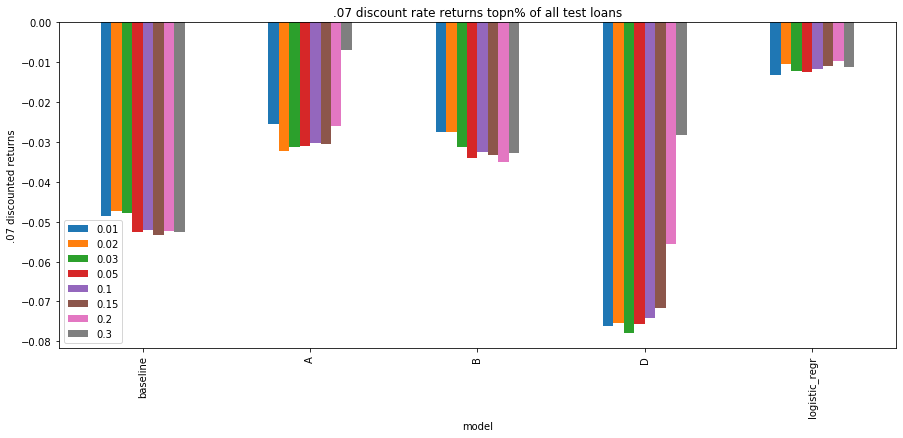

In [191]:
# whole_topn
ax = wtn_df.loc[chk_models].plot(kind='bar', figsize=(15,6), title='.07 discount rate returns topn% of all test loans')
ax.set_xlabel('model')
ax.set_ylabel('.07 discounted returns')

Text(0, 0.5, 'percent default of topn% picked')

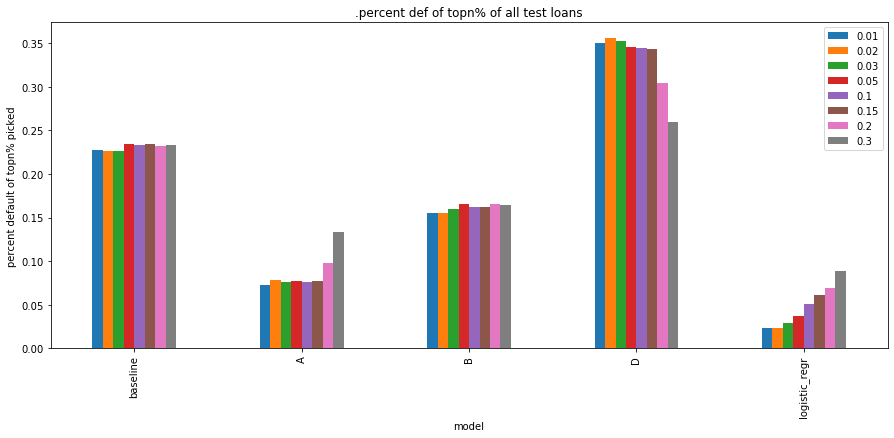

In [192]:
# whole_topn_def
ax = wtndef_df.loc[chk_models].plot(kind='bar', figsize=(15,6), title='.percent def of topn% of all test loans')
ax.set_xlabel('model')
ax.set_ylabel('percent default of topn% picked')

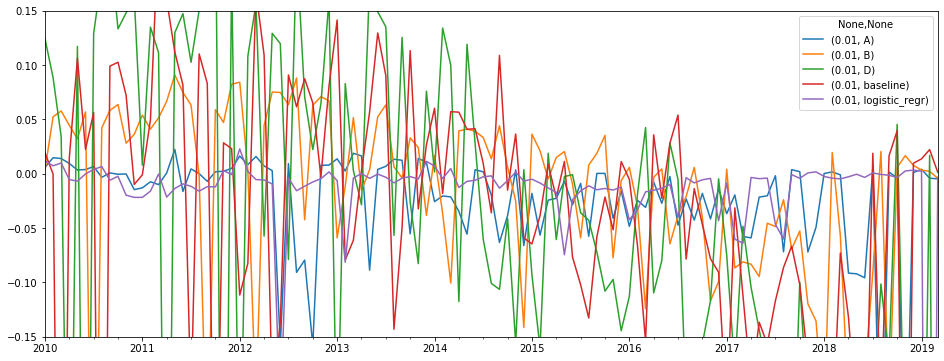

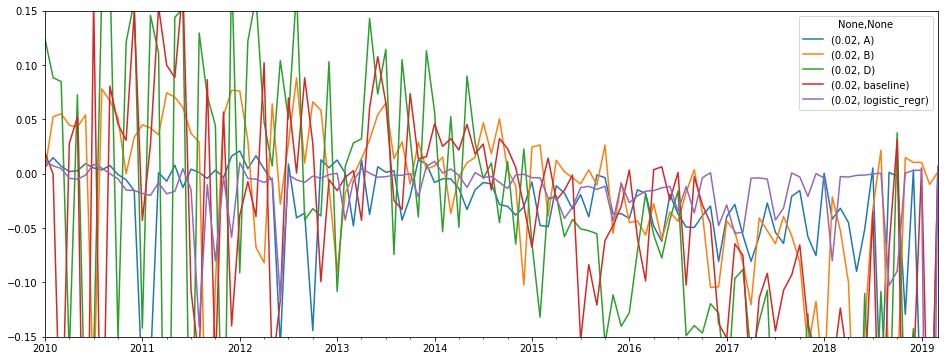

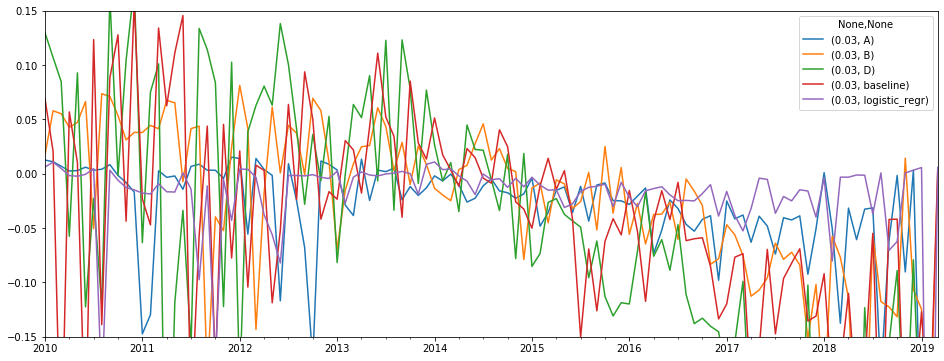

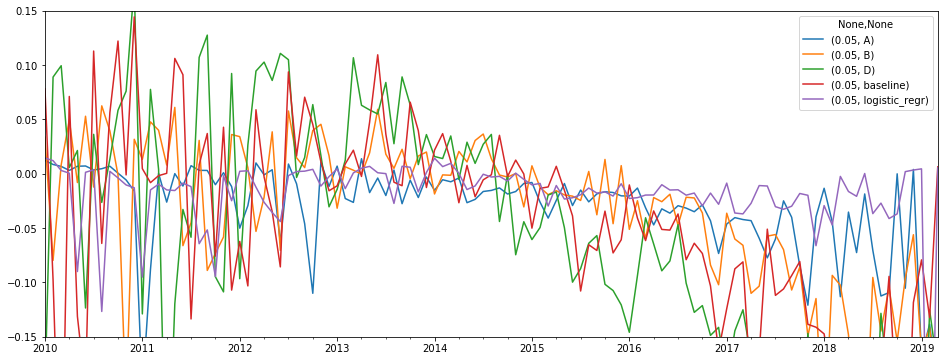

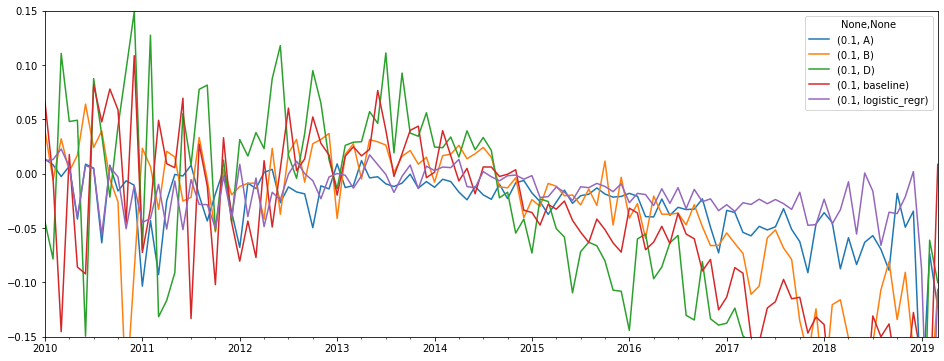

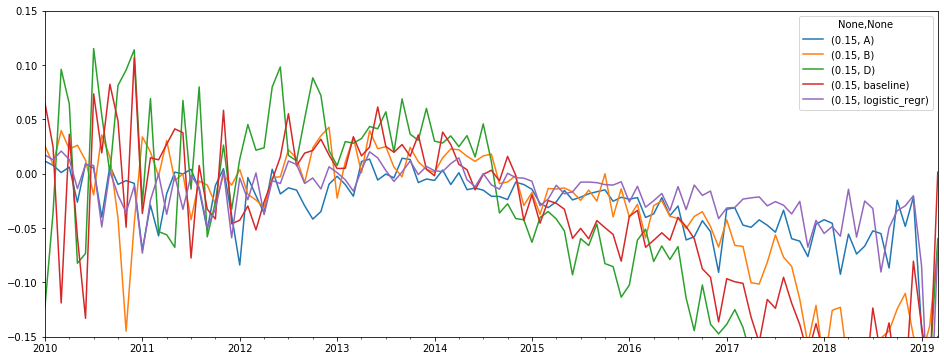

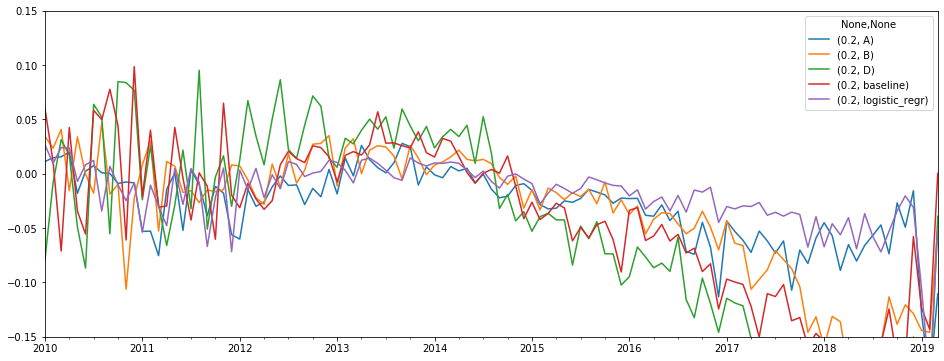

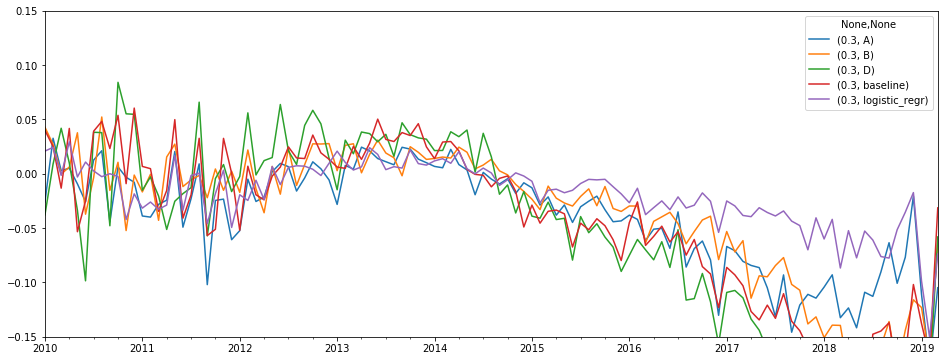

In [199]:
# mbm_topn
plot_mbm(mbm_df.loc[:, slicer], )#xlims=xlims)

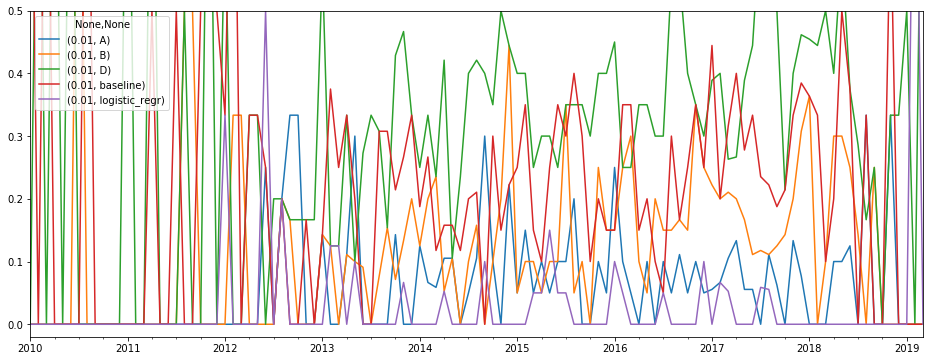

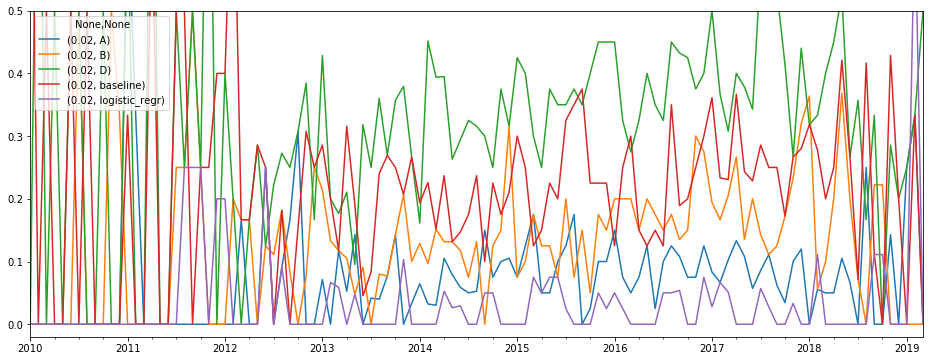

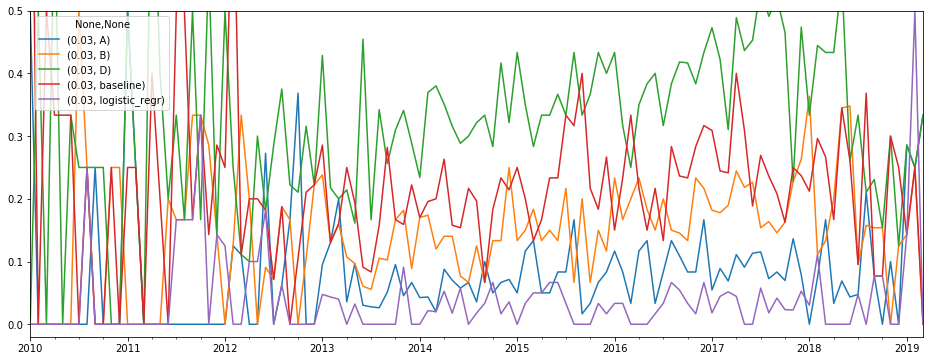

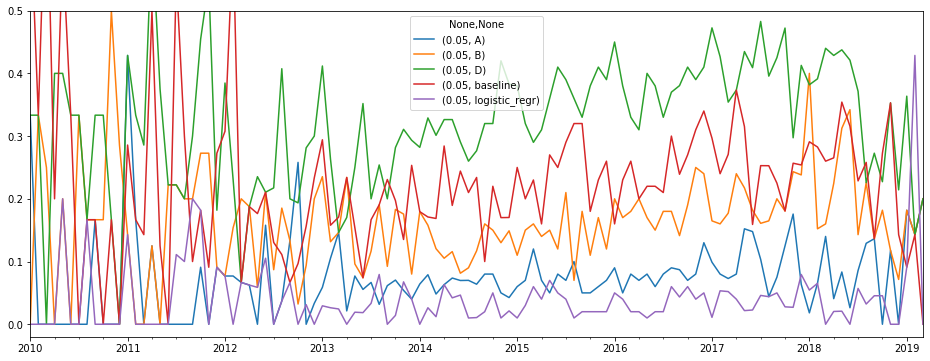

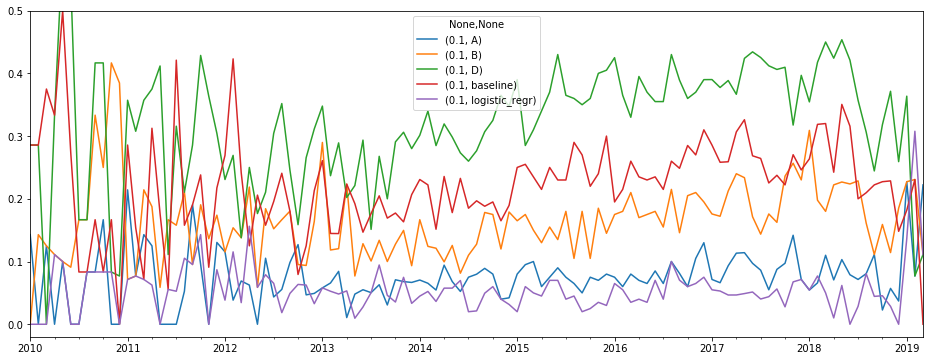

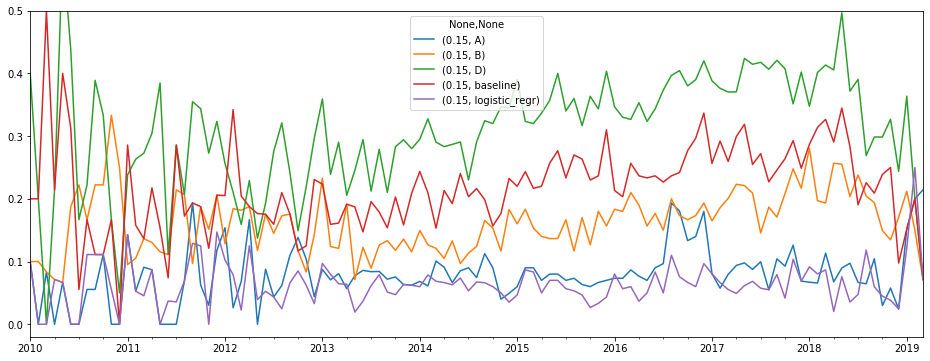

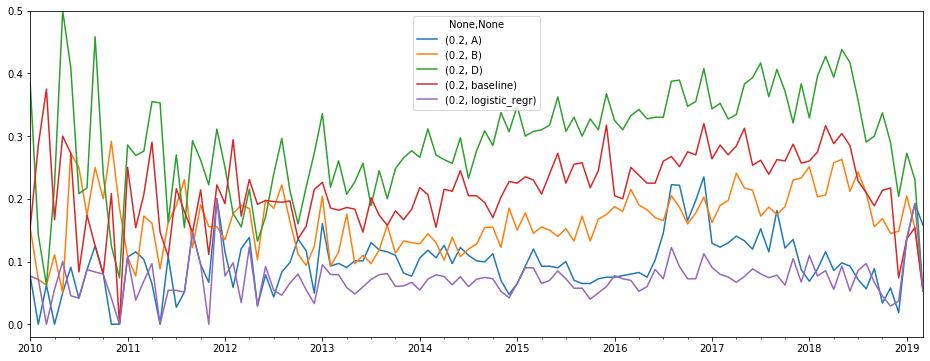

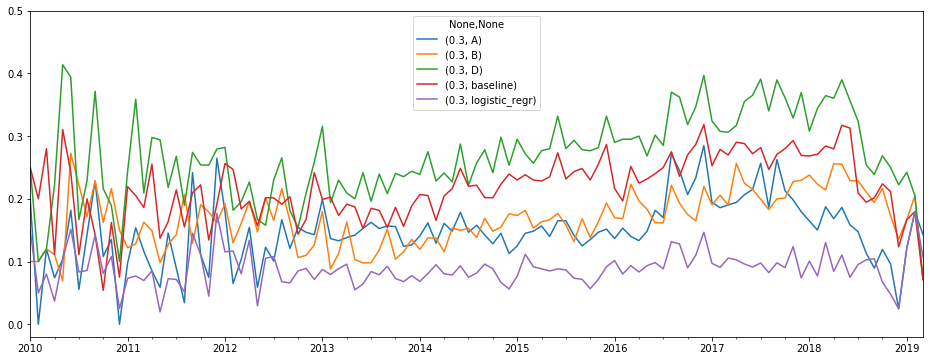

In [200]:
plot_mbm(mbmdef_df.loc[:, slicer], -0.02, .5, )

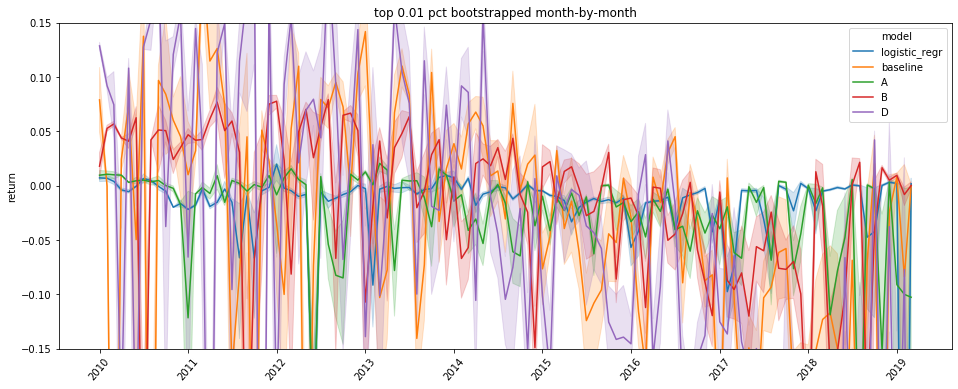

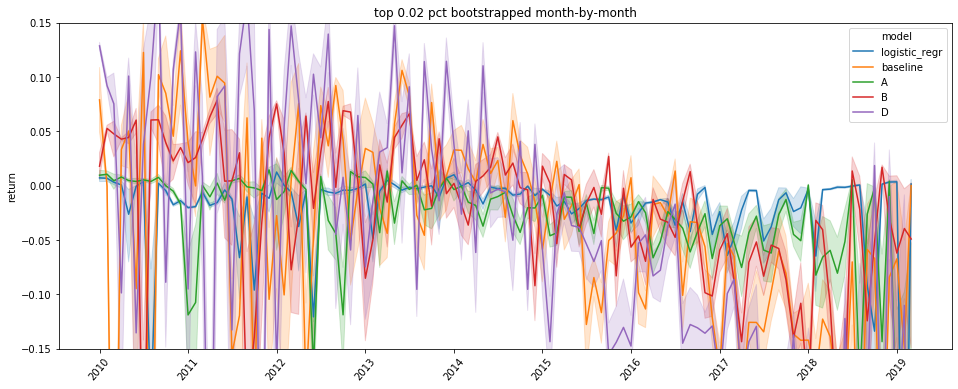

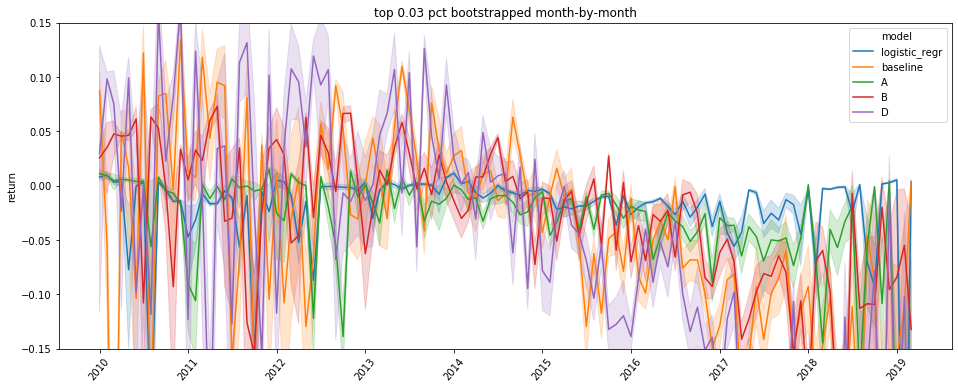

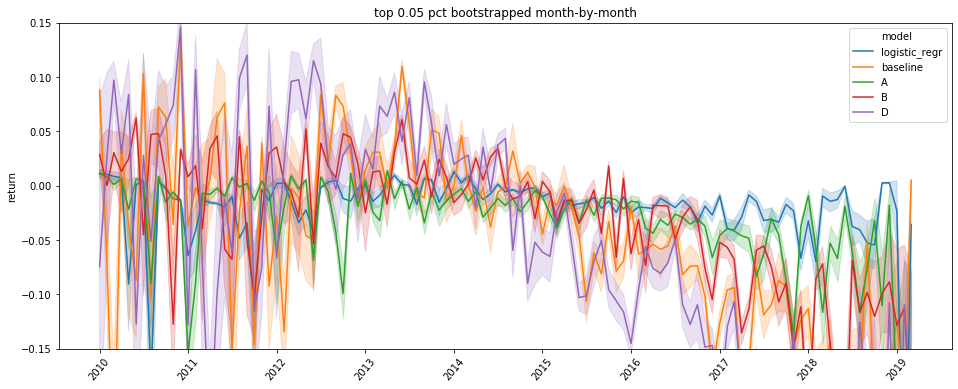

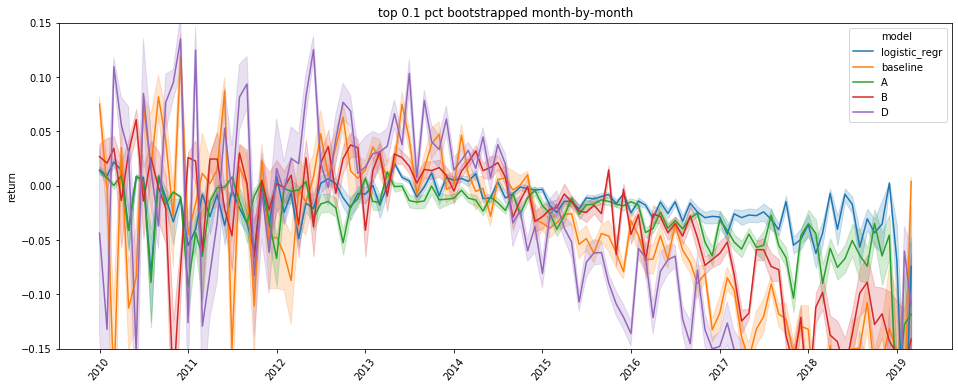

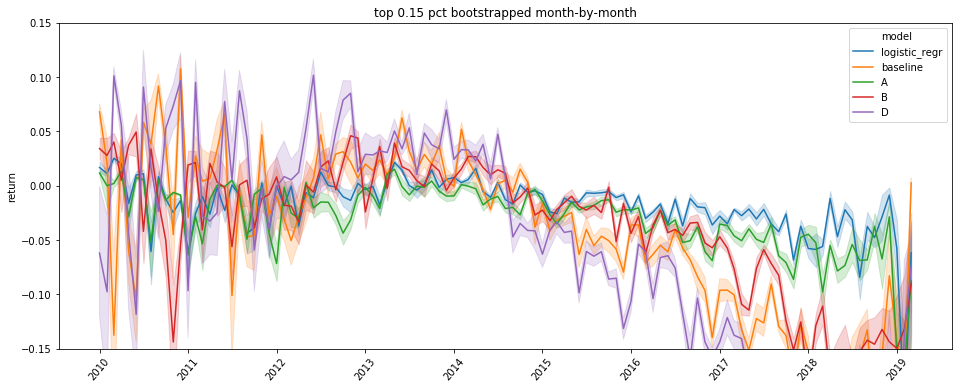

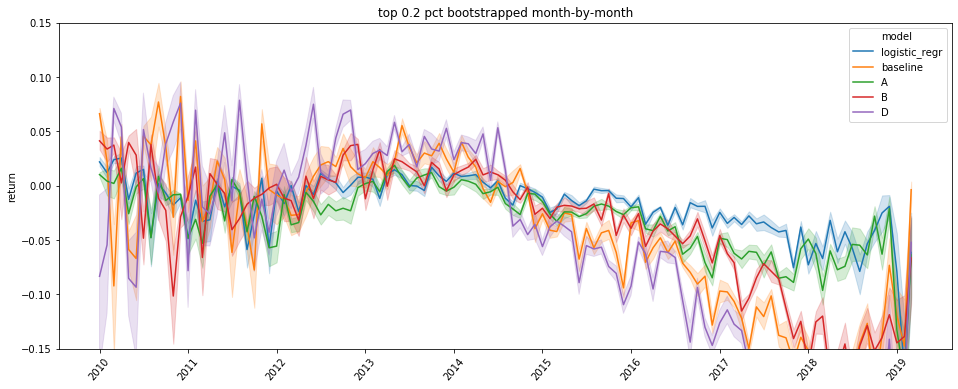

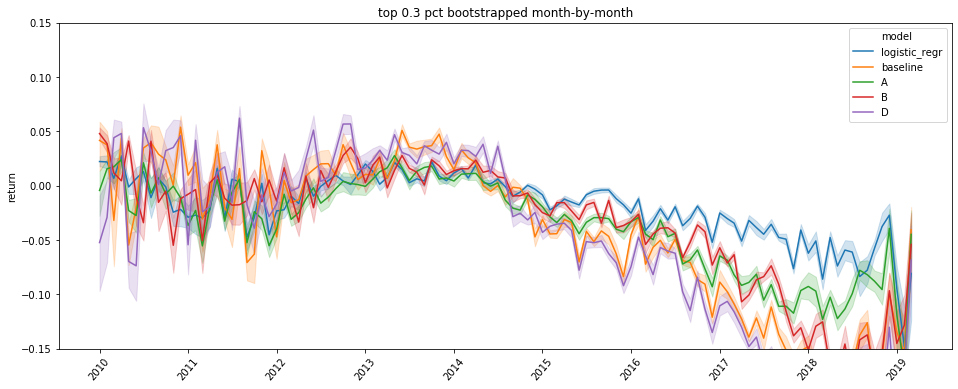

In [201]:
plot_bsmbm(bsmbm_df[bsmbm_df['model'].isin(chk_models)], )

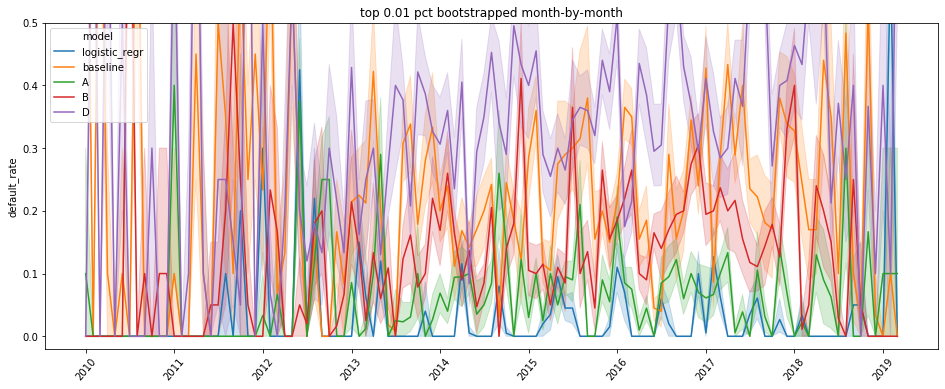

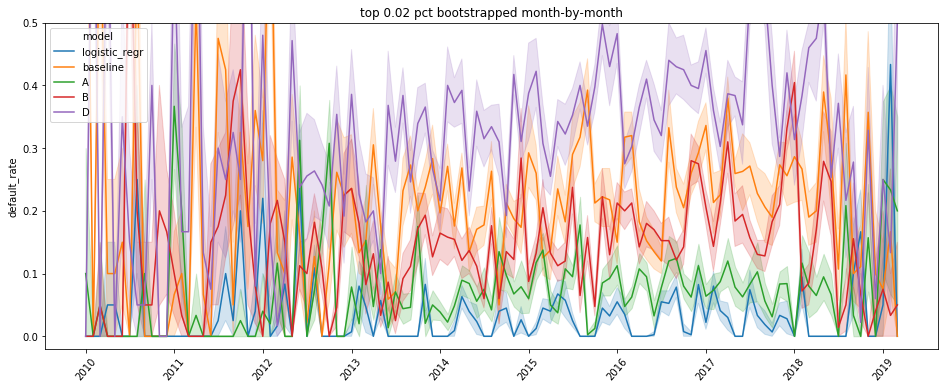

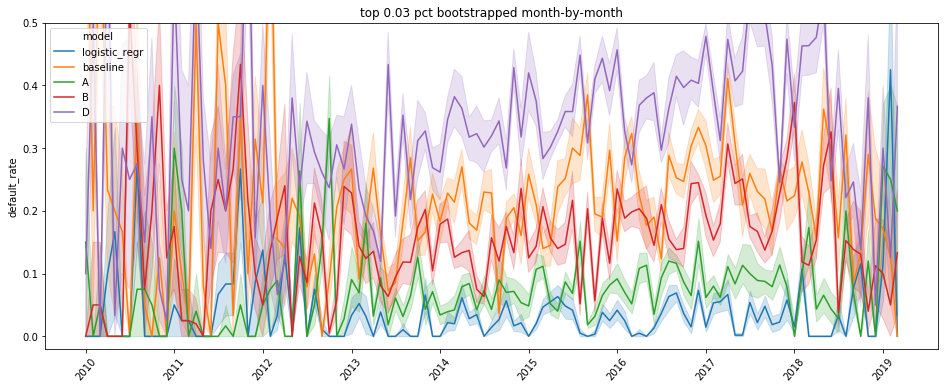

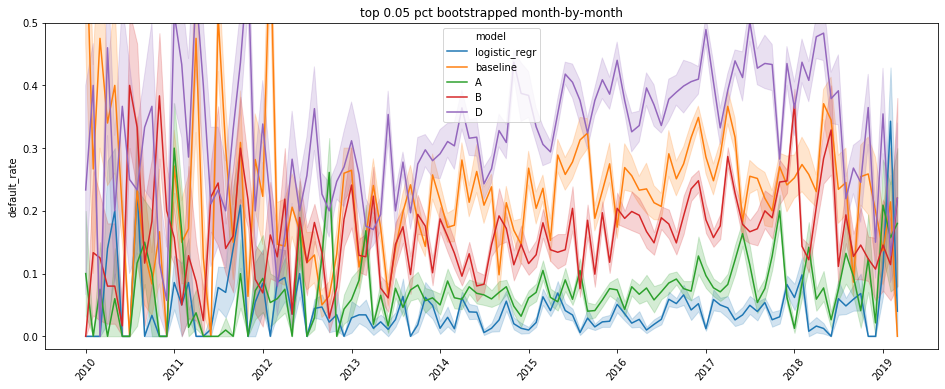

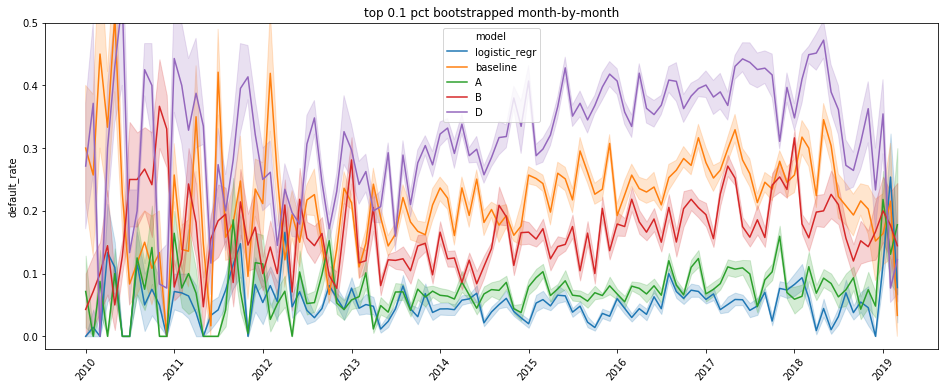

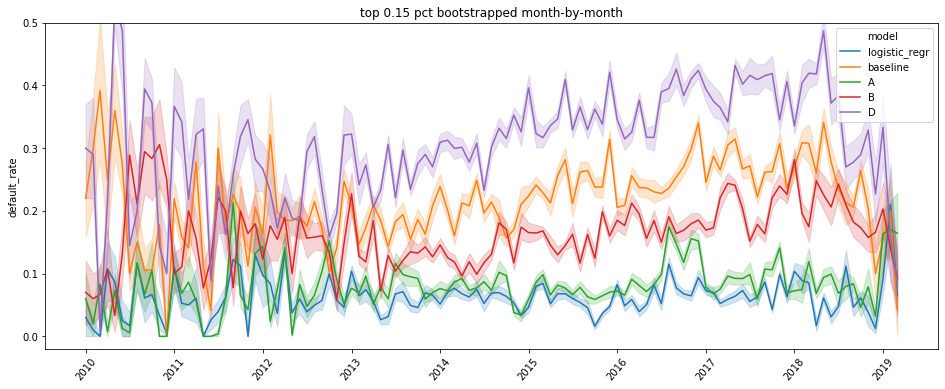

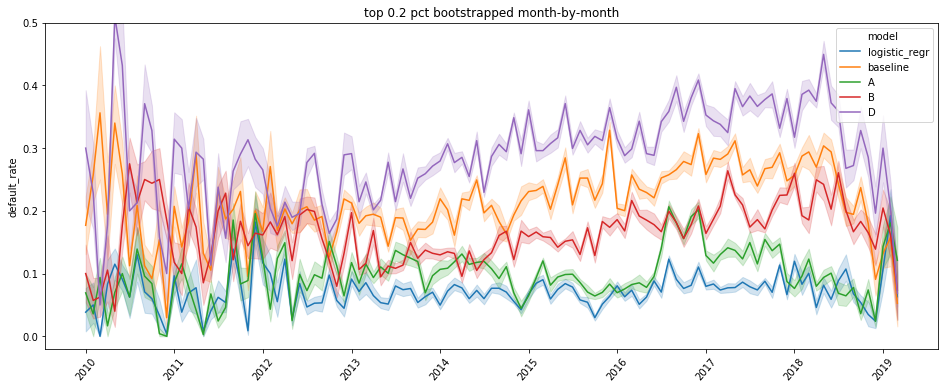

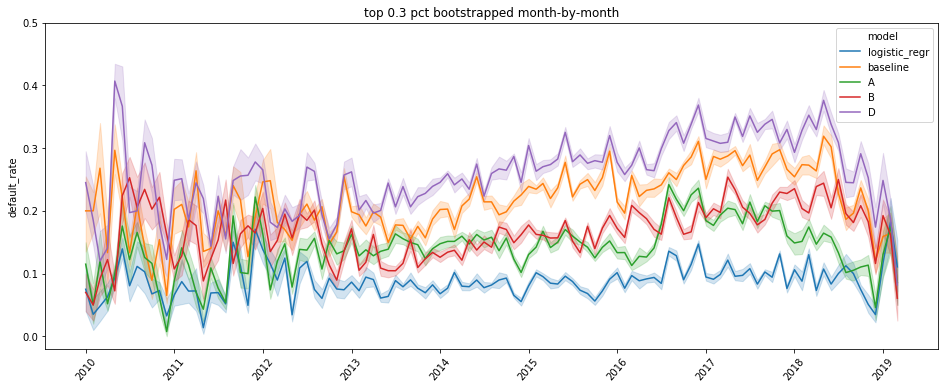

In [212]:
plot_bsmbm(bsmbmdef_df[bsmbmdef_df['model'].isin(chk_models)], -0.02, .5, target='default_rate')

# resave the new dfs

In [213]:
wtn_df.to_csv(os.path.join(dpath, 'whole_topn_df.csv'),)
wtndef_df.to_csv(os.path.join(dpath, 'whole_topn_def_df.csv'),)
mbm_df.to_csv(os.path.join(dpath, 'mbm_topn_df.csv'),)
mbmdef_df.to_csv(os.path.join(dpath, 'mbm_topn_def_df.csv'),)
bsmbm_df.to_csv(os.path.join(dpath, 'bsmbm_topn_df.csv'),)
bsmbmdef_df.to_csv(os.path.join(dpath, 'bsmbm_topn_def_df.csv'),)

# check saved

In [214]:
wtn_df = pd.read_csv(os.path.join(dpath, 'whole_topn_df.csv'), index_col=0, )
wtndef_df = pd.read_csv(os.path.join(dpath, 'whole_topn_def_df.csv'), index_col=0)
mbm_df = pd.read_csv(os.path.join(dpath, 'mbm_topn_df.csv'), index_col=0, header=[0,1])
mbm_df.index = pd.to_datetime(mbm_df.index)
mbmdef_df = pd.read_csv(os.path.join(dpath, 'mbm_topn_def_df.csv'), index_col=0, header=[0,1])
mbmdef_df.index = pd.to_datetime(mbmdef_df.index)
bsmbm_df = pd.read_csv(os.path.join(dpath, 'bsmbm_topn_df.csv'), index_col=0, parse_dates=['month'])
bsmbmdef_df = pd.read_csv(os.path.join(dpath, 'bsmbm_topn_def_df.csv'), index_col=0, parse_dates=['month'])

# old

In [219]:
# models = ['baseline', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
# top_n = [.01, .02, .03, .05, .1, .15, .2, .3]
# bs_groups = [idg0, idg1, idg2, idg3, idg4, idg5, idg6, idg7, idg8, idg9]
# issue_d_g = test_eval_loan_info.groupby('issue_d')

# full = {}
# mbm = {}
# bsmbm = {}
# full_def = {}
# mbm_def = {}
# bsmbm_def = {}
# for n in tqdm(top_n):
#     full_h = {}
#     mbm_h = {}
#     bsmbm_h = {}
#     full_def_h = {}
#     mbm_def_h = {}
#     bsmbm_def_h = {}
    
#     for model in models:
#         # get overall top n%
#         full_h[model] = get_topn_ret(model, test_eval_loan_info, n)
#         full_def_h[model] = get_topn_def_pct(model, test_eval_loan_info, n)
        
#         # get month by month
#         temp_mbm = {}
#         temp_mbm_def = {}
#         for d, g in issue_d_g:
#             temp_mbm[d] = get_topn_ret(model, g, n)
#             temp_mbm_def[d] = get_topn_def_pct(model, g, n)
#         mbm_h[model] = temp_mbm
#         mbm_def_h[model] = temp_mbm_def
            
#         # get bsmbm
#         temp_bsmbm = {}
#         temp_bsmbm_def = {}
#         for i, grouper in enumerate(bs_groups):
#             temp = {}
#             temp_def = {}
#             for d, g in grouper:
#                 temp[d] = get_topn_ret(model, g, n)
#                 temp_def[d] = get_topn_def_pct(model, g, n)
#             temp_bsmbm[i] = temp
#             temp_bsmbm_def[i] = temp_def
#         bsmbm_h[model] = temp_bsmbm
#         bsmbm_def_h[model] = temp_bsmbm_def
            
            
#     full[n] = full_h
#     mbm[n] = mbm_h
#     bsmbm[n] = bsmbm_h
#     full_def[n] = full_def_h
#     mbm_def[n] = mbm_def_h
#     bsmbm_def[n] = bsmbm_def_h